In [0]:
########## Import ############
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [4]:
print(torch.cuda.current_device())

0


In [4]:
#### Load the MNIST dataset #####
train_data = datasets.MNIST('~/data/mnist/', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST('~/data/mnist/', train=False, transform=transforms.ToTensor(), download=True)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
            shuffle=True, num_workers=4, drop_last=True)

Processing...
Done!


In [0]:
def view_samples(samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

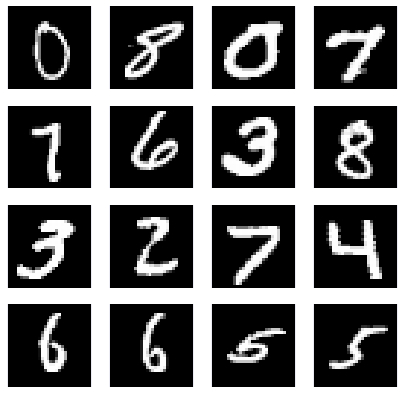

In [6]:
############### Viewing 16 random images from MNIST training set #############
ind = np.random.choice(len(train_data), 16)
samples = []
for i in ind:
  samples.append(train_data[i][0].numpy())
_ = view_samples(np.array(samples).transpose(0,2,3,1))

In [0]:
class Params():
  def __init__(self):
    self.n_inputs = 28
    self.n_steps = 28
    self.hidden_size = 150
    self.n_class = 10
    self.batch_size = 64

params = Params()

The following is a very simple RNN model. Given an input image with size 28x28, the model takes each vertical slice at each time step (28 time steps in total corresponding to the width of the image). We only care about the output of the last cell, which we will place a fully-connected layer on top of it.

![alt text](https://drive.google.com/uc?export=view&id=160sTFXOqdj9DrQ1ncTqeROhSdYI8KKAE)

In [0]:
class MNISTRnn(nn.Module):
  def __init__(self):
    super(MNISTRnn, self).__init__()
    self.n_inputs = params.n_inputs
    self.n_steps = params.n_steps
    self.hidden_size = params.hidden_size
    self.batch_size = params.batch_size
    self.n_class = params.n_class
    self.rnn = nn.RNN(self.n_inputs, self.hidden_size)
    self.fc = nn.Linear(self.hidden_size, self.n_class)
  
  def initHidden(self):
    # num layers, batch size, hidden size
    return torch.zeros(1, self.batch_size, self.hidden_size)
  
  def forward(self, images):
    images = images.squeeze(1)
    x = images.permute(1,0,2) # w, n, h
    hidden = self.initHidden()
    out, h_out = self.rnn(x, hidden) #out: seq_len, batch, hidden_size
    out = out[-1].view([out.shape[1], out.shape[2]])
    out = self.fc(out)
    return out.view(-1, self.n_class)

In [0]:
model = MNISTRnn()
# model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
def train():
  epochs = 15
  for epoch in range(epochs):
    print('Epoch {}\{}'.format(epoch+1, epochs))
    tot_loss = 0.0
    correct = 0.0
    for data in data_loader:
      inputs, labels = data
      inputs, labels = Variable(inputs), Variable(labels)
      optimizer.zero_grad()
      logits = model(inputs)
      _, preds = torch.max(logits.data,1)
      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()
      tot_loss += loss.item()
      correct += torch.sum(preds == labels.data)
    print('Epoch loss: ', tot_loss/len(train_data))
    print('Epoch acc: ', correct.item()/len(train_data))
  return model

In [13]:
model = train()

Epoch 1\15
Epoch loss:  0.006483014023924867
Epoch acc:  0.8758833333333333
Epoch 2\15
Epoch loss:  0.004173276517291864
Epoch acc:  0.9226333333333333
Epoch 3\15
Epoch loss:  0.0032637021272753676
Epoch acc:  0.9402666666666667
Epoch 4\15
Epoch loss:  0.002858921030039589
Epoch acc:  0.94655
Epoch 5\15
Epoch loss:  0.002574704956139127
Epoch acc:  0.9521
Epoch 6\15
Epoch loss:  0.0022891208888341985
Epoch acc:  0.95875
Epoch 7\15
Epoch loss:  0.0021091509114330013
Epoch acc:  0.9614166666666667
Epoch 8\15
Epoch loss:  0.0020254748895764353
Epoch acc:  0.9629666666666666
Epoch 9\15
Epoch loss:  0.001958647893431286
Epoch acc:  0.9641666666666666
Epoch 10\15
Epoch loss:  0.0017322820233802
Epoch acc:  0.9678666666666667
Epoch 11\15
Epoch loss:  0.0017813670593003431
Epoch acc:  0.9670833333333333
Epoch 12\15
Epoch loss:  0.0017370454554756483
Epoch acc:  0.96815
Epoch 13\15
Epoch loss:  0.001603533312305808
Epoch acc:  0.9704166666666667
Epoch 14\15
Epoch loss:  0.0015322198727478584
Ep